# 3가지 방식 사용

- 설명은 GPT 참조하였습니다.
---

### 1. 히스토그램 일치화 (Histogram Equalization)

히스토그램 일치화는 이미지의 히스토그램을 고르게 분포하도록 변경하는 방법입니다.
- 주로 이미지의 대비를 향상시키기 위해 사용됩니다.
- 일치화를 통해 어두운 영역과 밝은 영역 모두에 있는 정보를 더 잘 보이게 할 수 있습니다.
- 흑백 이미지에 주로 적용되지만 컬러 이미지의 경우 YUV나 HSV와 같은 다른 색 공간으로 변환하여 Y 채널이나 V 채널에 히스토그램 일치화를 적용할 수 있습니다.

### 2. Z-Score 정규화 (Z-Score Normalization)

Z-Score 정규화는 각 픽셀 값을 해당 이미지의 픽셀 값 평균에서 뺀 다음 픽셀 값의 표준편차로 나누는 방법입니다.

공식:
\[ Z = \frac{X - \mu}{\sigma} \]
- \( Z \): Z-Score 정규화된 값
- \( X \): 원래 픽셀 값
- \( \mu \): 이미지의 픽셀 값 평균
- \( \sigma \): 이미지의 픽셀 값 표준편차

- 이 방법은 이미지의 평균을 0으로, 표준편차를 1로 만들어 데이터를 표준화합니다.
- 딥러닝 모델의 입력 데이터로 이미지를 사용할 때 자주 사용되는 방법 중 하나입니다.

### 3. Min-Max 정규화 (Min-Max Normalization)

Min-Max 정규화는 이미지의 픽셀 값을 해당 이미지의 최소 픽셀 값과 최대 픽셀 값 사이로 스케일링하는 방법입니다.

공식:
\[ S = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}} \]
- \( S \): Min-Max 정규화된 값
- \( X \): 원래 픽셀 값
- \( X_{\text{min}} \): 이미지의 최소 픽셀 값
- \( X_{\text{max}} \): 이미지의 최대 픽셀 값

- 이 방법은 모든 픽셀 값을 0과 1 사이로 만듭니다.
- 이미지의 픽셀 값 범위를 제한하거나 통일하고 싶을 때 사용됩니다.

---



In [1]:
import pandas as pd
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2

In [2]:
Thickness = pd.read_csv('./data/Thickness.csv')
Thickness = Thickness.drop([33]) # 9-1 drop
Thickness.reset_index(drop=True, inplace=True)

top_path = './data/box_img/Top/'
bot_path = './data/box_img/Bot/'

top_path_list = [f'./data/box_img/Top/Top_{i}.jpg' for i in range(0, 127)]
bot_path_list = [f'./data/box_img/Bot/Bot_{i}.jpg' for i in range(0, 127)]

In [3]:
Thickness

,Thickness
0,48.266667
1,47.966667
2,48.166667
3,48.600000
4,59.533333
...,...
122,84.633333
123,98.366667
124,97.033333
125,96.266667


- Reference 보정을 위해 기본값을 정하고 Weight를 줘서 보정을 해주면 되지 않을까?

In [4]:
import cv2

def apply_histogram_equalization(img_array):
    """Apply histogram equalization to the image."""
    img_yuv = cv2.cvtColor(img_array, cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

def apply_zscore_normalization(img_array):
    """Apply Z-Score normalization to the image."""
    mean_pixel = np.mean(img_array)
    std_dev_pixel = np.std(img_array)
    return (img_array - mean_pixel) / std_dev_pixel

def apply_minmax_normalization(img_array):
    """Apply Min-Max normalization to the image."""
    min_pixel = np.min(img_array)
    max_pixel = np.max(img_array)
    return (img_array - min_pixel) / (max_pixel - min_pixel)

# Using the given code with added standardization steps
Base_img = np.array(Image.open(top_path_list[0]))
Top_transformed_list_histogram = []
Top_transformed_list_zscore = []
Top_transformed_list_minmax = []

for i in range(len(bot_path_list)):
    bot_img = np.array(Image.open(bot_path_list[i]))
    top_img = np.array(Image.open(top_path_list[i]))
    base_img = np.array(Image.open(bot_path_list[0]))
    
    # Histogram Equalization
    bot_img_histogram = apply_histogram_equalization(bot_img)
    base_img_histogram = apply_histogram_equalization(base_img)
    Bot_transformed_histogram = bot_img_histogram / (base_img_histogram + 1e-7) #0이되지 않게끔
    Top_transformed_histogram = top_img * Bot_transformed_histogram
    Top_transformed_list_histogram.append(Top_transformed_histogram)
    
    # Z-Score Normalization
    bot_img_zscore = apply_zscore_normalization(bot_img)
    base_img_zscore = apply_zscore_normalization(base_img)
    Bot_transformed_zscore = bot_img_zscore / (base_img_zscore + 1e-7)
    Top_transformed_zscore = top_img * Bot_transformed_zscore
    Top_transformed_list_zscore.append(Top_transformed_zscore)
    
    # Min-Max Normalization
    bot_img_minmax = apply_minmax_normalization(bot_img)
    base_img_minmax = apply_minmax_normalization(base_img)
    Bot_transformed_minmax = bot_img_minmax / (base_img_minmax + 1e-7)
    Top_transformed_minmax = top_img * Bot_transformed_minmax
    Top_transformed_list_minmax.append(Top_transformed_minmax)


In [5]:
import os

# Define a function to save the images
def save_images(image_list, base_path, prefix):
    """
    Save the list of images to the specified path with a given prefix.
    
    Args:
    - image_list (list): List of numpy arrays representing images.
    - base_path (str): Directory where images will be saved.
    - prefix (str): Prefix for the image filenames.
    """
    for idx, img in enumerate(image_list):
        img_path = os.path.join(base_path, f"{prefix}_{idx}.jpg")
        Image.fromarray((img * 255).astype(np.uint8)).save(img_path)

# Set base path for saving the images
save_path = './corrected_images/'

# Ensure the save directory exists
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Save the images for each correction method
save_images(Top_transformed_list_histogram, save_path, "histogram")
save_images(Top_transformed_list_zscore, save_path, "zscore")
save_images(Top_transformed_list_minmax, save_path, "minmax")


### AutoML 먼저 시도

In [6]:
top_avg_rgb_hist = []
top_avg_rgb_zscore = []
top_avg_rgb_minmax = []

for i in range(len(Top_transformed_list_histogram)):
    top = Top_transformed_list_histogram[i]
    Top_R, Top_G, Top_B = np.mean(top[:,:,0]), np.mean(top[:,:,1]), np.mean(top[:,:,2])
    
    top_avg_rgb_hist.append([Top_R, Top_G, Top_B])
    
for i in range(len(Top_transformed_list_zscore)):
    top = Top_transformed_list_zscore[i]
    top_R, top_G, top_B = np.mean(top[:,:,0]), np.mean(top[:,:,1]), np.mean(top[:,:,2])
    
    top_avg_rgb_zscore.append([top_R, top_G, top_B])
    
for i in range(len(Top_transformed_list_minmax)):
    top = Top_transformed_list_minmax[i]
    top_R, top_G, top_B = np.mean(top[:,:,0]), np.mean(top[:,:,1]), np.mean(top[:,:,2])
    
    top_avg_rgb_minmax.append([top_R, top_G, top_B])

In [7]:
top_avg_rgb_hist = np.array(top_avg_rgb_hist)
top_avg_rgb_zscore = np.array(top_avg_rgb_zscore)
top_avg_rgb_minmax = np.array(top_avg_rgb_minmax)

In [8]:
Table_dataset_hist = pd.DataFrame(np.concatenate([top_avg_rgb_hist, Thickness], axis = 1), columns=['R', 'G', 'B', 'Thickness'])
Table_dataset_zscore = pd.DataFrame(np.concatenate([top_avg_rgb_zscore, Thickness], axis = 1), columns=['R', 'G', 'B', 'Thickness'])
Table_dataset_minmax = pd.DataFrame(np.concatenate([top_avg_rgb_minmax, Thickness], axis = 1), columns=['R', 'G', 'B', 'Thickness'])

In [9]:
from tpot import TPOTRegressor

X_train_hist, X_test_hist, y_train_hist, y_test_hist = train_test_split(Table_dataset_hist.iloc[:,:-1], Table_dataset_hist.iloc[:,-1], test_size=0.3, random_state=42)
tpot_hist = TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42, cv=5, n_jobs = -1)
tpot_hist.fit(X_train_hist, y_train_hist)
tpot_hist.export('tpot_corrected_hist.py')

X_train_zscore, X_test_zscore, y_train_zscore, y_test_zscore = train_test_split(Table_dataset_zscore.iloc[:,:-1], Table_dataset_zscore.iloc[:,-1], test_size=0.3, random_state=42)
tpot_zscore = TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42, cv=5, n_jobs = -1)
tpot_zscore.fit(X_train_zscore, y_train_zscore)
tpot_zscore.export('tpot_corrected_zscore.py')

X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax = train_test_split(Table_dataset_minmax.iloc[:,:-1], Table_dataset_minmax.iloc[:,-1], test_size=0.3, random_state=42)
tpot_minmax = TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42, cv=5, n_jobs = -1)
tpot_minmax.fit(X_train_minmax, y_train_minmax)
tpot_minmax.export('tpot_corrected_minmax.py')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -124.83738434285685

Generation 2 - Current best internal CV score: -68.4114709661485

Generation 3 - Current best internal CV score: -68.19071152119923

Generation 4 - Current best internal CV score: -68.19071152119923

Generation 5 - Current best internal CV score: -68.19071152119923

Best pipeline: AdaBoostRegressor(RobustScaler(LassoLarsCV(input_matrix, normalize=True)), learning_rate=0.01, loss=linear, n_estimators=100)


Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -90.29586756568685

Generation 2 - Current best internal CV score: -73.5213886716239

Generation 3 - Current best internal CV score: -56.49381128063199

Generation 4 - Current best internal CV score: -56.49381128063199

Generation 5 - Current best internal CV score: -56.49381128063199

Best pipeline: AdaBoostRegressor(LassoLarsCV(input_matrix, normalize=False), learning_rate=1.0, loss=linear, n_estimators=100)


Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -99.69383583404424

Generation 2 - Current best internal CV score: -99.69383583404424

Generation 3 - Current best internal CV score: -97.67741988255266

Generation 4 - Current best internal CV score: -97.67741988255266

Generation 5 - Current best internal CV score: -94.7797757895752

Best pipeline: AdaBoostRegressor(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), learning_rate=0.5, loss=exponential, n_estimators=100)


In [10]:
y_pred_hist = tpot_hist.predict(X_test_hist)
y_pred_zscore = tpot_zscore.predict(X_test_zscore)
y_pred_minmax = tpot_minmax.predict(X_test_minmax)

c:\Users\se99a\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LassoLarsCV was fitted with feature names
  warnings.warn(
c:\Users\se99a\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LassoLarsCV was fitted with feature names
  warnings.warn(


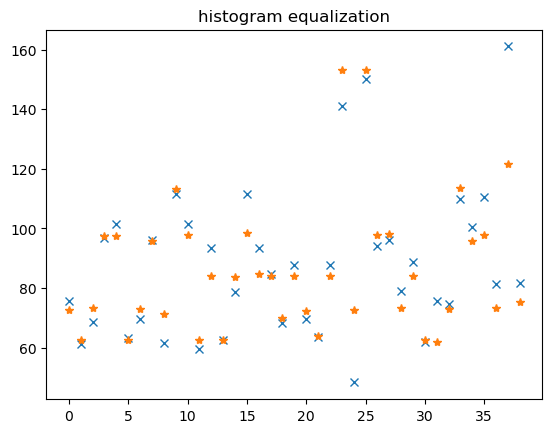

In [16]:
plt.title("histogram equalization")
plt.plot(y_test_hist.values,'x', label = 'True')
plt.plot(y_pred_hist,'*', label = 'Predict')

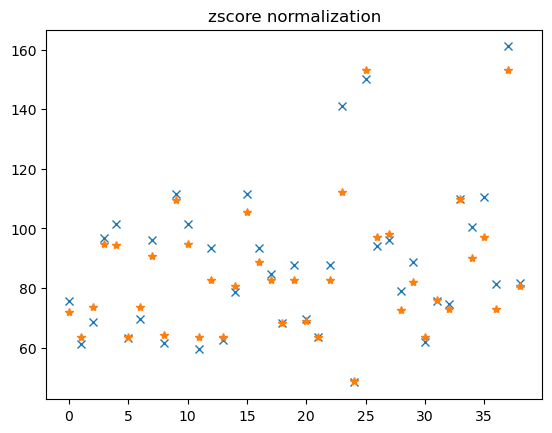

In [17]:
plt.title("zscore normalization")
plt.plot(y_test_zscore.values,'x', label = 'True')
plt.plot(y_pred_zscore,'*', label = 'Predict')

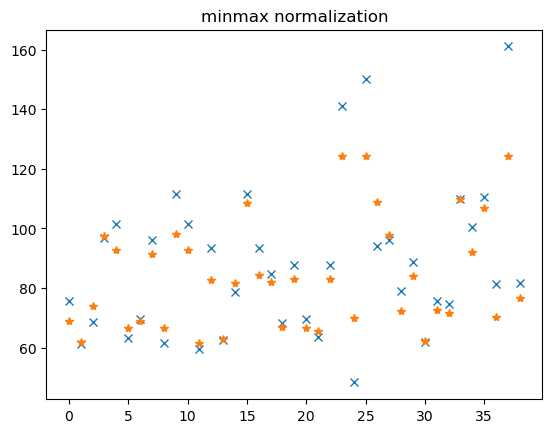

In [18]:
plt.title("minmax normalization")
plt.plot(y_test_minmax.values,'x', label = 'True')
plt.plot(y_pred_minmax,'*', label = 'Predict')

In [19]:
hist_result = pd.DataFrame({'True': y_test_hist.values, 'Predict': y_pred_hist})
zscore_result = pd.DataFrame({'True': y_test_zscore.values, 'Predict': y_pred_zscore})
minmax_result = pd.DataFrame({'True': y_test_minmax.values, 'Predict': y_pred_minmax})

hist_result.to_csv('./data/hist_result.csv', index=False)
zscore_result.to_csv('./data/zscore_result.csv', index=False)
minmax_result.to_csv('./data/minmax_result.csv', index=False)

In [20]:
hist_mse = np.mean((y_test_hist.values - y_pred_hist)**2)
zscore_mse = np.mean((y_test_zscore.values - y_pred_zscore)**2)
minmax_mse = np.mean((y_test_minmax.values - y_pred_minmax)**2)

print(hist_mse, zscore_mse, minmax_mse)

89.262987790551 46.9737364881852 103.6730398184102
